In [112]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [114]:
!pip install pysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
!pip install numpy==1.23.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
!pip uninstall numba
!pip install -U numba

Found existing installation: numba 0.57.0
Uninstalling numba-0.57.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.10/dist-packages/numba-0.57.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numba/*
Proceed (Y/n)? Y
  Successfully uninstalled numba-0.57.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numba-0.57.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.6 MB)


In [117]:
!pip install contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
%matplotlib inline

import osmnx as ox
import seaborn as sns
import pandas as pd

from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
#from pysal.viz.splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation

import geopandas as gpd
import numpy as np

import contextily as ctx
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

In [119]:
#Upload the files you will work with

#Import crashes
db = pd.read_csv('/content/drive/MyDrive/Geospatial Data Science/Project progress/geoclean1619.csv')

#Import comunas
c = gpd.read_file('/content/drive/MyDrive/Geospatial Data Science/Project progress/catastro.geojson')

#Import barrios
b = gpd.read_file('/content/drive/MyDrive/Geospatial Data Science/Project progress/barrios.geojson')

#Import the limits of Medellin
l = ox.geocode_to_gdf('Medellin, Colombia')

In [120]:
#Drop duplicated values within filed_id

db = db.drop_duplicates(subset=['filed_id'])

In [121]:
#Clean the coordinates that fall out of Medellin
db = db[db['latitude'] >= l['bbox_south'].iloc[0]]
db = db[db['latitude'] <= l['bbox_north'].iloc[0]]

db = db[db['longitude'] <= l['bbox_east'].iloc[0]]
db = db[db['longitude'] >= l['bbox_west'].iloc[0]]

In [122]:
#Set the severity and the crucial hours

db = db[db['accident_severity'] == 'Injured']

In [123]:
#Add geometry to crashes database
geo = gpd.points_from_xy(x=db['longitude'], y=db['latitude'], crs='EPSG:4326')

gdb = gpd.GeoDataFrame(db, geometry=geo)

In [124]:
#Drop columns from comunas and barrios db

c = c.drop(['SECTOR', 'SHAPE__Area', 'SHAPE__Length'], axis=1)

#Filter columns out of Medellin

c['COMUNA'] = c['COMUNA'].astype(str).astype(int)

c = c[c['COMUNA'] <= 16]

b = b.drop(['INDICADOR_UR', 'SHAPE__Area', 'SHAPE__Length'], axis=1)

b['COMUNA'] = b['COMUNA'].astype(str).astype(int)

b = b[b['COMUNA'] <= 16]

b = b.reset_index()

In [125]:
#b = b.drop(['level_0', 'index'], axis=1)

In [126]:
#Create the GeoDataFrame joining crashes and neighborhoods

cr_b = gpd.sjoin(gdb, b, how='inner')

cr_b = cr_b.drop(['Unnamed: 0'], axis=1)

cr_b = cr_b.reset_index()

In [127]:
#Create counts by neighborhood

cr_b_count = cr_b.groupby('OBJECTID').count()

cr_b_count = cr_b_count[['filed_id']]

cr_b_count.rename(columns={'filed_id': 'crashes'}, inplace=True)

#Assign counts into a barrios table

cr_b_count = cr_b_count.reset_index()

b = b.merge(cr_b_count, on='OBJECTID', how='inner')

In [128]:
cr_b_count.sum()

OBJECTID    1835422
crashes       89681
dtype: int64

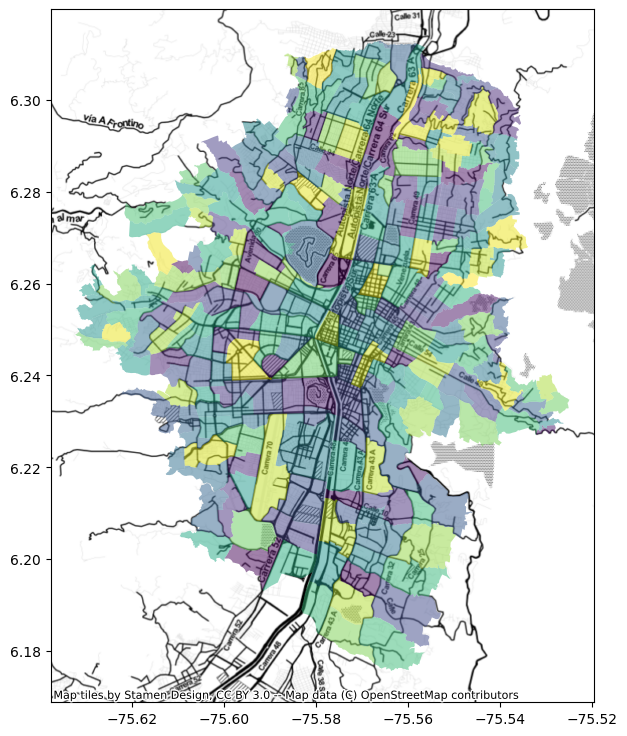

In [129]:
#Plot the neighborhoods of Medellin

ax = b.plot(column='OBJECTID', figsize=(9,9), alpha=0.5)

ctx.add_basemap(ax,
                crs=b.crs,
                source=ctx.providers.Stamen.Toner)

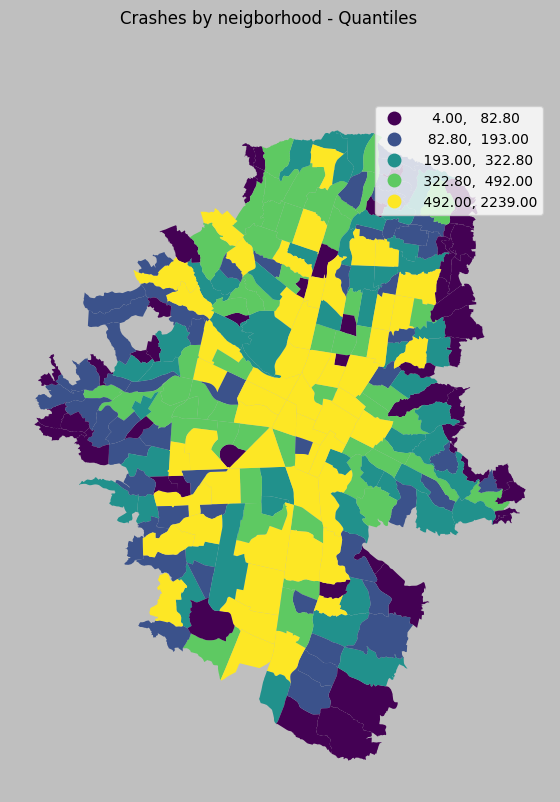

In [130]:
#Plot a choroplet of Medellin

f, ax = plt.subplots(1, figsize=(9,9))

b.plot(column='crashes',
       scheme='quantiles',
       legend=True,
       ax=ax)

ax.set_axis_off()

f.set_facecolor('0.75')

f.suptitle('Crashes by neigborhood - Quantiles', size=12)

plt.show()

##Weight matrix based on contiguity

###Queen contiguity

In [131]:
w_queen = weights.Queen.from_dataframe(b, idVariable='OBJECTID')

In [132]:
#Compute a Series to know the queen contiguity neighbors

queen_n = pd.Series(w_queen.cardinalities)

In [133]:
#Delete islands because of contiguity

queen_isl = w_queen.islands

for i in queen_isl:
  bq = b[b['OBJECTID'] != i]

#Recompute w_queen without considering islands

wq = weights.Queen.from_dataframe(bq, idVariable='OBJECTID')

#Row-standarized

wq.transform = 'R'

#Create a Series containing the queen contiguity

queen_n = pd.Series(wq.cardinalities)

('WARNING: ', 6790, ' is an island (no neighbors)')
('WARNING: ', 6864, ' is an island (no neighbors)')
('WARNING: ', 6914, ' is an island (no neighbors)')


(0.0, 15.0)

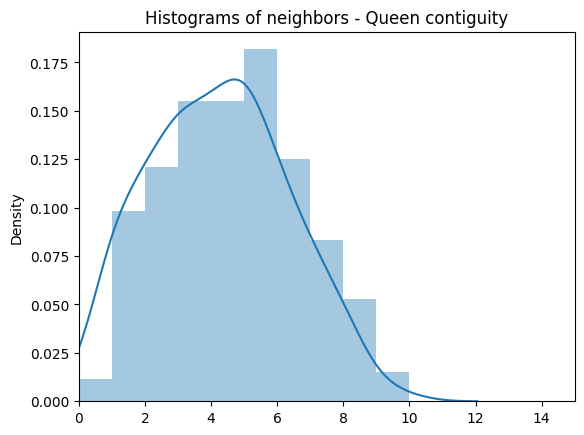

In [134]:
sns.distplot(queen_n, bins=10)

plt.title('Histograms of neighbors - Queen contiguity')

plt.xlim(0, 15)

In [135]:
#Now, let's compute the spatial lag considering queen contiguity

bq['queen_cr'] = weights.lag_spatial(wq, bq['crashes'])

In [136]:
bq.sort_values(by=['crashes'], ascending=False).head(10)

,index,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BARRIO,SECTOR,NOMBRE_COMUNA,geometry,crashes,queen_cr
243,317,7070,0511,5,11,Castilla,2,CASTILLA,"POLYGON ((-75.57052 6.29433, -75.57027 6.29423...",2239,407.000000
67,90,6843,1507,15,07,Campo Amor,6,GUAYABAL,"POLYGON ((-75.57763 6.21684, -75.57771 6.21626...",1751,796.400000
111,148,6901,1019,10,19,La Candelaria,3,LA CANDELARIA,"POLYGON ((-75.56726 6.25403, -75.56737 6.25374...",1651,904.714286
54,70,6823,1012,10,12,Perpetuo Socorro,3,LA CANDELARIA,"POLYGON ((-75.57545 6.23979, -75.57545 6.23978...",1634,800.142857
246,322,7075,0517,5,17,Caribe,2,CASTILLA,"POLYGON ((-75.57260 6.27583, -75.57249 6.27581...",1578,556.571429
77,100,6853,1006,10,06,San Benito,3,LA CANDELARIA,"POLYGON ((-75.57331 6.25894, -75.57330 6.25893...",1378,847.875000
245,321,7074,1013,10,13,Barrio Colón,3,LA CANDELARIA,"POLYGON ((-75.56465 6.24364, -75.56508 6.24280...",1321,944.666667
110,147,6900,1504,15,04,Santa Fé,6,GUAYABAL,"POLYGON ((-75.57635 6.22593, -75.57636 6.22583...",1260,885.166667
203,263,7016,1105,11,05,Los Conquistadores,4,LAURELES,"POLYGON ((-75.58940 6.23926, -75.58968 6.23924...",1231,613.800000
175,227,6980,1001,10,01,Prado,3,LA CANDELARIA,"POLYGON ((-75.55821 6.26238, -75.55826 6.26229...",1086,466.000000


In [137]:
wq.neighbors[6823]

[6849, 7074, 6900, 7016, 7001, 6842, 6776]

In [138]:
#Let's compute the standard value of crahses
bq['crashes_std'] = (bq['crashes'] - bq['crashes'].mean())/bq['crashes'].std()

bq['queen_cr_std'] = weights.lag_spatial(wq, bq['crashes_std'])

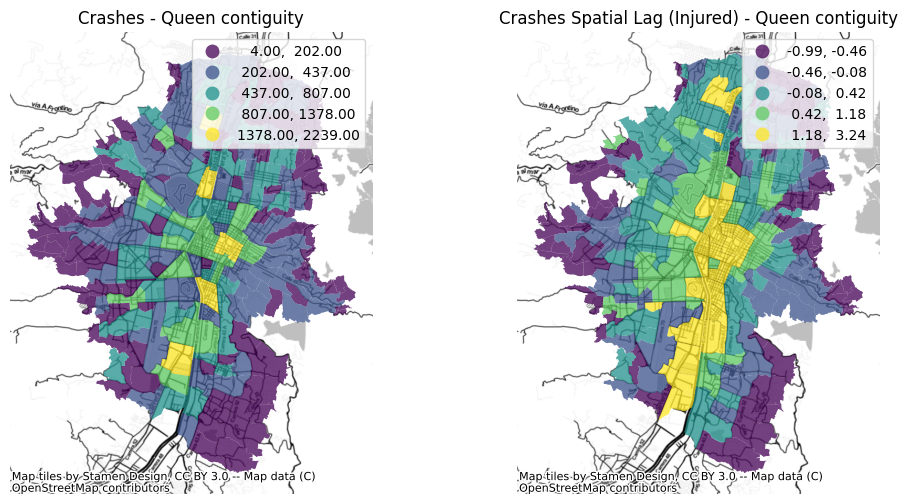

In [167]:
f, axs = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axs

bq.plot(column='crashes',
       cmap='viridis',
       scheme='naturalbreaks',
       edgecolor='white',
       linewidth=0.,
       alpha=0.75,
       legend=True,
       ax=ax1)

ax1.set_axis_off()
ax1.set_title('Crashes - Queen contiguity')

ctx.add_basemap(ax1,
                crs=bq.crs,
                source=ctx.providers.Stamen.Toner)

bq.plot(column='queen_cr_std',
        cmap='viridis',
        scheme='naturalbreaks',
        edgecolor='white',
        linewidth=0.,
        alpha=0.75,
        legend=True,
        ax=ax2)

ax2.set_axis_off()
ax2.set_title('Crashes Spatial Lag (Injured) - Queen contiguity')

ctx.add_basemap(ax2,
                crs=bq.crs,
                source=ctx.providers.Stamen.Toner)

plt.show()

###Rook contiguity

In [140]:
w_rook = weights.Rook.from_dataframe(b, idVariable='OBJECTID')

In [141]:
#Compute a Series to know the queen contiguity neighbors

rook_n = pd.Series(w_rook.cardinalities)

In [142]:
w_rook.islands

[6790, 6864, 6914, 6957, 6975]

In [143]:
#Delete islands because of contiguity

rook_isl = w_rook.islands

for i in rook_isl:
  br = b[b['OBJECTID'] != i]

#Recompute w_queen without considering islands

wr = weights.Rook.from_dataframe(br, idVariable='OBJECTID')

#Row-standarized

wr.transform = 'R'

#Create a Series containing the queen contiguity

rook_n = pd.Series(wr.cardinalities)

('WARNING: ', 6790, ' is an island (no neighbors)')
('WARNING: ', 6864, ' is an island (no neighbors)')
('WARNING: ', 6914, ' is an island (no neighbors)')
('WARNING: ', 6957, ' is an island (no neighbors)')


(0.0, 15.0)

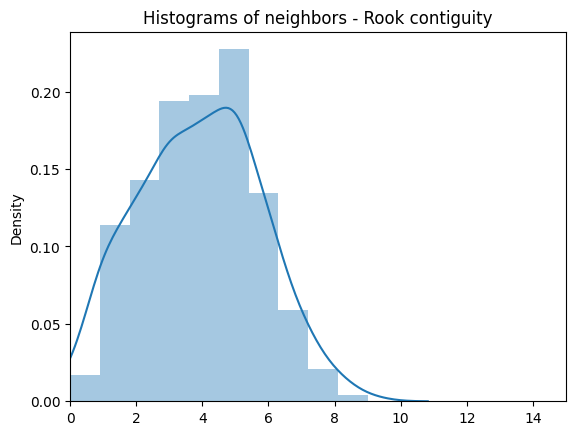

In [144]:
sns.distplot(rook_n, bins=10)

plt.title('Histograms of neighbors - Rook contiguity')

plt.xlim(0, 15)

In [145]:
#Now, let's compute the spatial lag considering rook contiguity

br['rook_cr'] = weights.lag_spatial(wr, br['crashes'])

In [146]:
br.sort_values(by=['crashes'], ascending=False).head()

,index,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BARRIO,SECTOR,NOMBRE_COMUNA,geometry,crashes,rook_cr
243,317,7070,0511,5,11,Castilla,2,CASTILLA,"POLYGON ((-75.57052 6.29433, -75.57027 6.29423...",2239,370.000000
67,90,6843,1507,15,07,Campo Amor,6,GUAYABAL,"POLYGON ((-75.57763 6.21684, -75.57771 6.21626...",1751,796.400000
111,148,6901,1019,10,19,La Candelaria,3,LA CANDELARIA,"POLYGON ((-75.56726 6.25403, -75.56737 6.25374...",1651,904.714286
54,70,6823,1012,10,12,Perpetuo Socorro,3,LA CANDELARIA,"POLYGON ((-75.57545 6.23979, -75.57545 6.23978...",1634,622.000000
246,322,7075,0517,5,17,Caribe,2,CASTILLA,"POLYGON ((-75.57260 6.27583, -75.57249 6.27581...",1578,524.166667


In [147]:
wr.neighbors[7074]

[6931, 6901, 6823, 6842, 6780]

In [148]:
#Let's compute the standard value of crahses
br['crashes_std'] = (bq['crashes'] - bq['crashes'].mean())/bq['crashes'].std()

br['rook_cr_std'] = weights.lag_spatial(wr, br['crashes_std'])

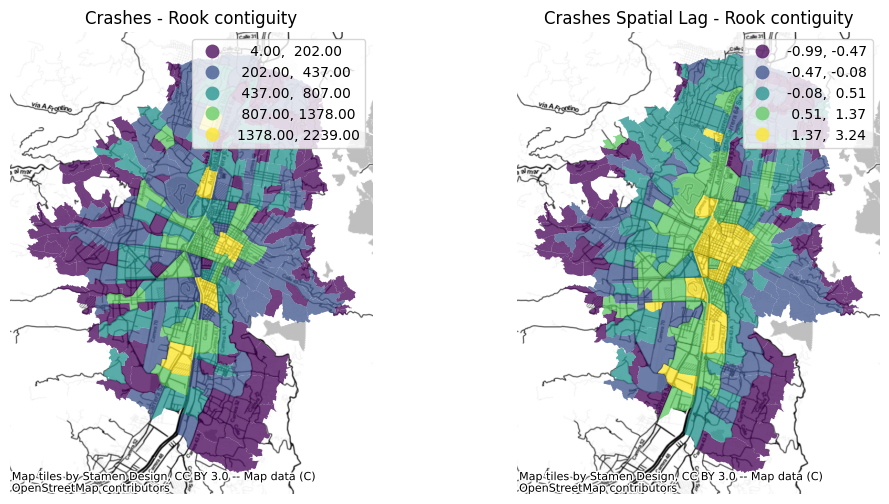

In [149]:
f, axs = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axs

br.plot(column='crashes',
       cmap='viridis',
       scheme='naturalbreaks',
       edgecolor='white',
       linewidth=0.,
       alpha=0.75,
       legend=True,
       ax=ax1)

ax1.set_axis_off()
ax1.set_title('Crashes - Rook contiguity')

ctx.add_basemap(ax1,
                crs=br.crs,
                source=ctx.providers.Stamen.Toner)

br.plot(column='rook_cr_std',
        cmap='viridis',
        scheme='naturalbreaks',
        edgecolor='white',
        linewidth=0.,
        alpha=0.75,
        legend=True,
        ax=ax2)

ax2.set_axis_off()
ax2.set_title('Crashes Spatial Lag - Rook contiguity')

ctx.add_basemap(ax2,
                crs=br.crs,
                source=ctx.providers.Stamen.Toner)

plt.show()

##Weight matrix based on distance

In [150]:
#Let's compute a new database considering projected coordinates
b_d = b.to_crs(epsg=3857)

#Also, compute the weight matrix considering neighbors within a range of 2 km

wd_2 = weights.DistanceBand.from_dataframe(b_d, 2000, binary=False)

#Now, let's compute the spatial lag considering rook contiguity

b_d['distance_cr'] = weights.lag_spatial(wd_2, b_d['crashes'])

In [151]:
#Let's compute the standard value of crahses
b_d['crashes_std'] = (b_d['crashes'] - b_d['crashes'].mean())/b_d['crashes'].std()

b_d['distance_cr_std'] = weights.lag_spatial(wd_2, b_d['crashes_std'])

In [152]:
b_d.sort_values(by=['crashes'], ascending=False).head()

,index,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BARRIO,SECTOR,NOMBRE_COMUNA,geometry,crashes,distance_cr,crashes_std,distance_cr_std
243,317,7070,0511,5,11,Castilla,2,CASTILLA,"POLYGON ((-8412472.003 702095.275, -8412443.84...",2239,10.650614,5.707547,0.001134
67,90,6843,1507,15,07,Campo Amor,6,GUAYABAL,"POLYGON ((-8413263.063 693417.899, -8413272.20...",1751,6.855745,4.242057,0.006546
111,148,6901,1019,10,19,La Candelaria,3,LA CANDELARIA,"POLYGON ((-8412108.389 697582.438, -8412120.97...",1651,18.201278,3.941752,0.027077
54,70,6823,1012,10,12,Perpetuo Socorro,3,LA CANDELARIA,"POLYGON ((-8413021.082 695987.671, -8413020.37...",1634,11.783234,3.890700,0.014636
246,322,7075,0517,5,17,Caribe,2,CASTILLA,"POLYGON ((-8412703.672 700023.004, -8412690.65...",1578,12.848551,3.722529,0.008727


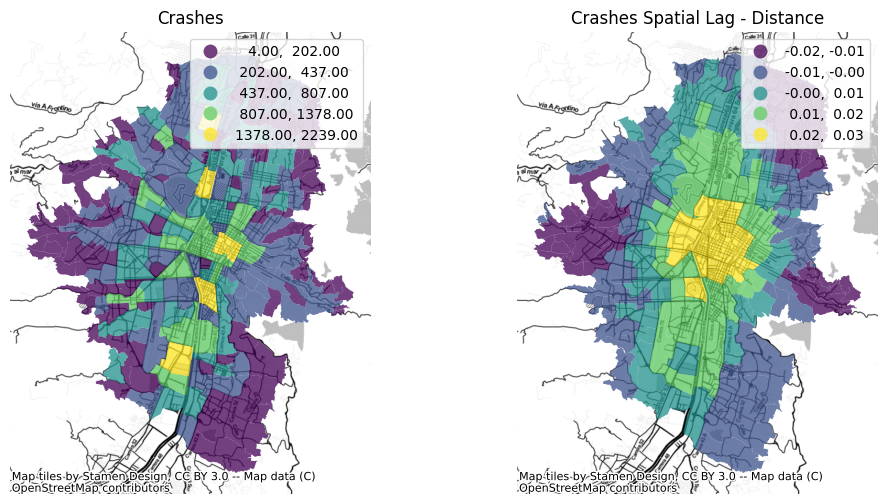

In [153]:
#Let's plot the spatial lag considering a weight matrix based on distance

f, axs = plt.subplots(1, 2, figsize=(12,6))
ax1, ax2 = axs

b_d.plot(column='crashes',
         cmap='viridis',
         scheme='naturalbreaks',
         edgecolor='white',
         linewidth=0.,
         alpha=0.75,
         legend=True,
         ax=ax1)

ax1.set_axis_off()
ax1.set_title('Crashes')

ctx.add_basemap(ax1,
                crs=b_d.crs,
                source=ctx.providers.Stamen.Toner)

b_d.plot(column='distance_cr_std',
         cmap='viridis',
         scheme='naturalbreaks',
         edgecolor='white',
         linewidth=0.,
         alpha=0.75,
         legend=True,
         ax=ax2)

ax2.set_axis_off()
ax2.set_title('Crashes Spatial Lag - Distance')

ctx.add_basemap(ax2,
                crs=b_d.crs,
                source=ctx.providers.Stamen.Toner)

plt.show()

#Global Spatial Autocorrelation

In [154]:
#Let's compute Moran's I for the different approaches considered

queen_mi = esda.Moran(bq['crashes'], wq)

rook_mi = esda.Moran(br['crashes'], wr)

distance_mi = esda.Moran(b_d['crashes'], wd_2)

In [155]:
#Let's print Moran's I for each approach
queen_mi.I, rook_mi.I, distance_mi.I

(0.3643995966802137, 0.3568308460394571, 0.22304183342214665)

In [156]:
#Let's print p-value for each approach
queen_mi.p_sim, rook_mi.p_sim, distance_mi.p_sim

(0.001, 0.001, 0.001)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.36', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.36)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

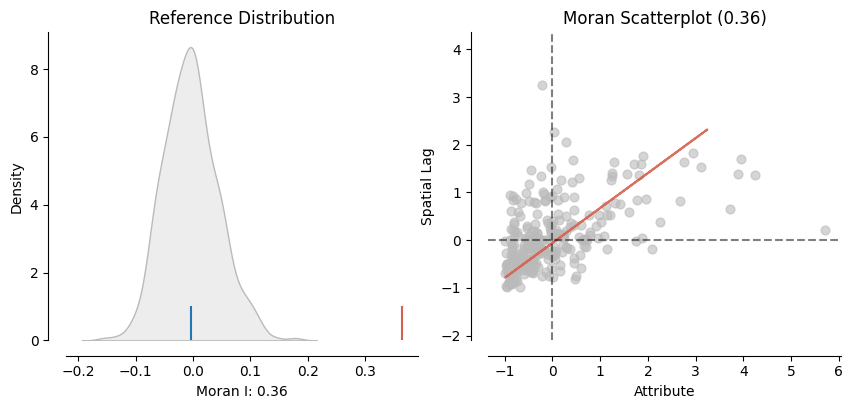

In [157]:
#Then, plot the Moran's I scatter plot and the reference distribution

from pysal.viz import splot
from splot.esda import plot_moran

plot_moran(queen_mi)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.36', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.36)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

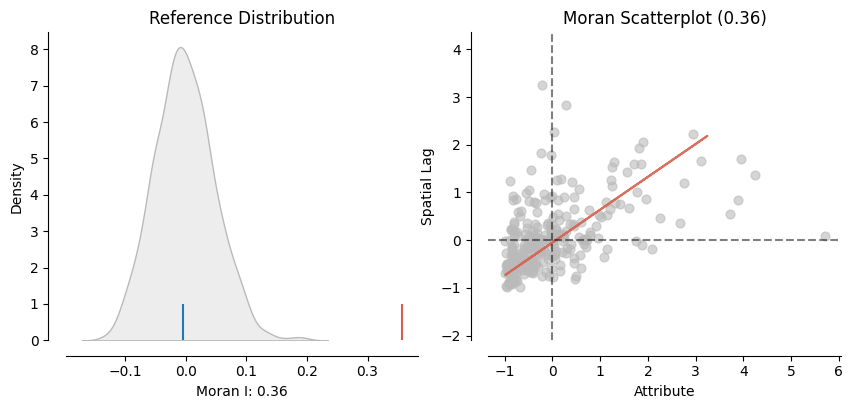

In [158]:
plot_moran(rook_mi)

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.22', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.22)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

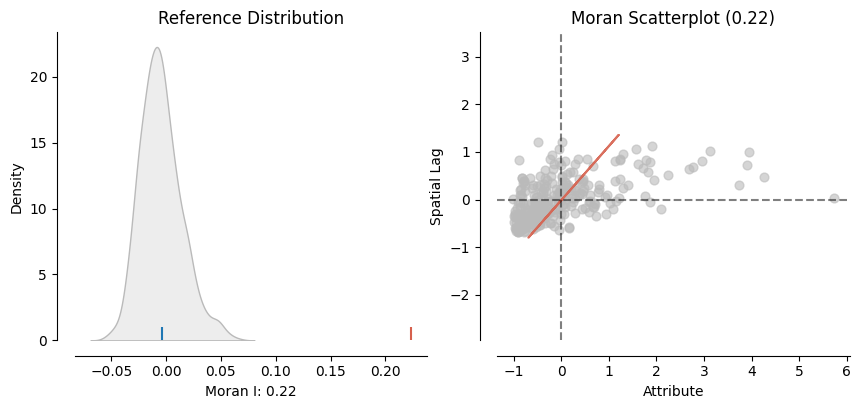

In [159]:
plot_moran(distance_mi)

#Local Spatial Autocorrelation

In [160]:
#Let's calculate the LISA for each of the approaches

queen_lisa = esda.Moran_Local(bq['crashes'], wq)

rook_lisa = esda.Moran_Local(br['crashes'], wr)

distance_lisa = esda.Moran_Local(b_d['crashes'], wd_2)

Text(0.5, 1.0, 'LISA for Queen contiguity')

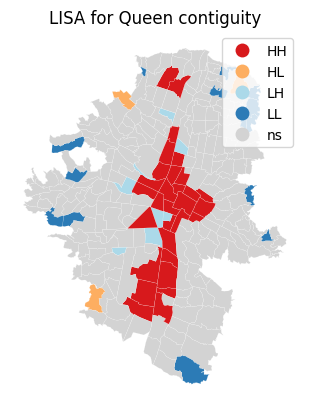

In [161]:
#Let's plot the hot and cold regions for Queen contiguity

from splot.esda import lisa_cluster

lisa_cluster(queen_lisa, bq)

plt.title('LISA for Queen contiguity')

Text(0.5, 1.0, 'LISA for Rook Contiguity')

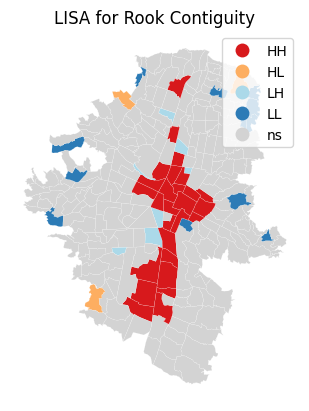

In [162]:
#Let's plot the hot and cold regions for Rook contiguity

lisa_cluster(rook_lisa, br)

plt.title('LISA for Rook Contiguity')

Text(0.5, 1.0, 'LISA for Distance')

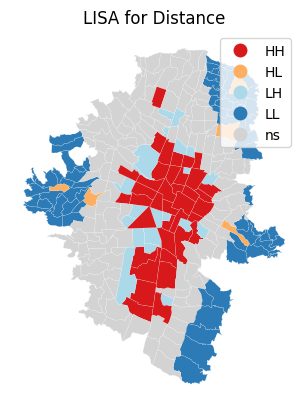

In [163]:
lisa_cluster(distance_lisa, b_d)

plt.title('LISA for Distance')

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

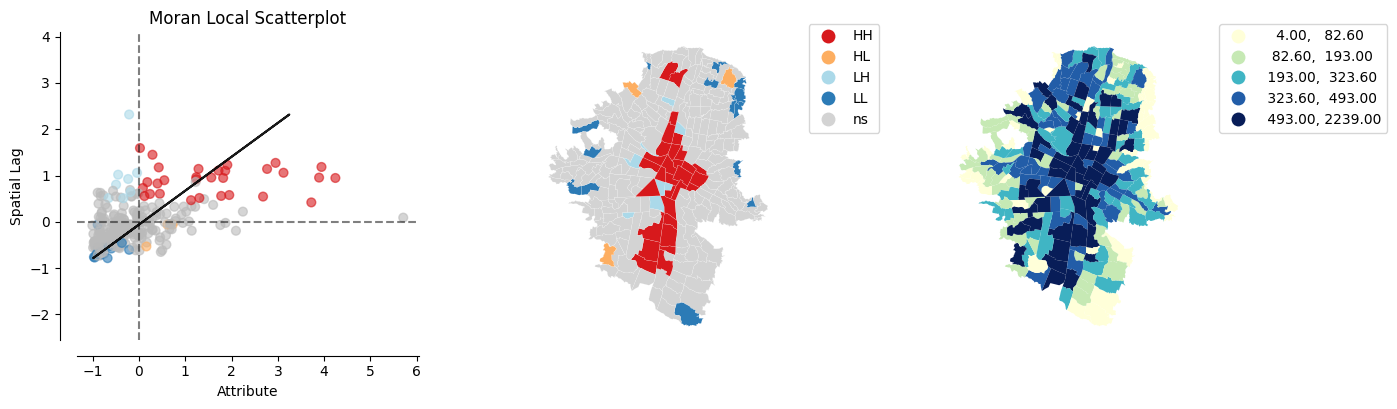

In [164]:
#Let's plot all the charts together
splot.esda.plot_local_autocorrelation(queen_lisa, bq, 'crashes')

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

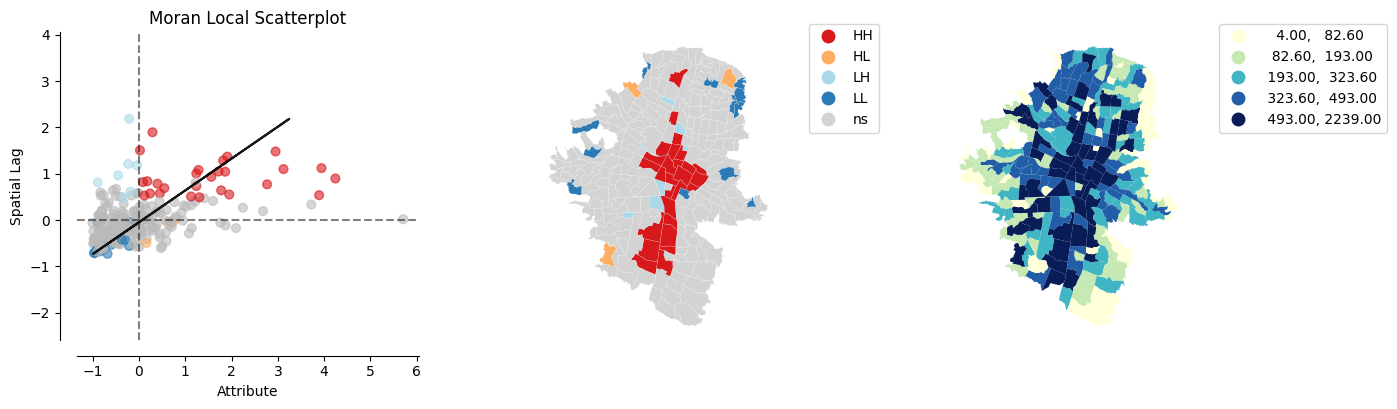

In [165]:
splot.esda.plot_local_autocorrelation(rook_lisa, br, 'crashes')

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: title={'center': 'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <Axes: >, <Axes: >], dtype=object))

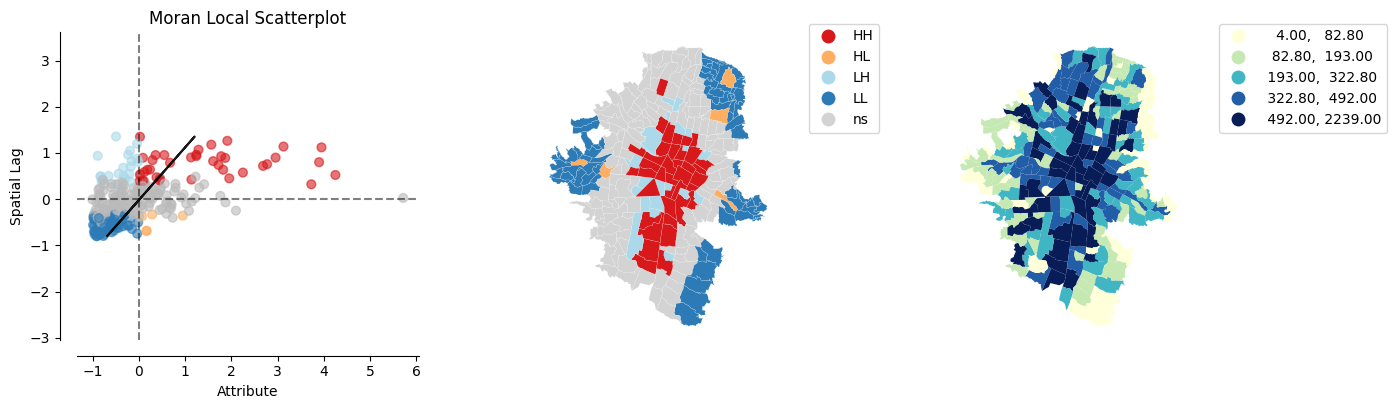

In [166]:
splot.esda.plot_local_autocorrelation(distance_lisa, b_d, 'crashes')